## **XGBoost Classifier**  
XGBoost is short for Extreme Gradient Boosting and is an efficient implementation of the stochastic gradient boosting machine learning algorithm. The stochastic gradient boosting algorithm, also called gradient boosting machines or tree boosting, is a powerful machine learning technique that performs well or even best on a wide range of challenging machine learning problems.  
It is an ensemble of decision trees algorithm where new trees fix errors of those trees that are already part of the model. Trees are added until no further improvements can be made to the model.  XGBoost is an effective machine learning model, even on datasets where the class distribution is skewed.  
Before any modification or tuning is made to the XGBoost algorithm for imbalanced classification, it is essential to test the default XGBoost model and establish a performance baseline.

In [1]:
import numpy as np # for numeric computation
import pandas as pd # for handling data in table format
pd.set_option('display.max_rows', 200)
import requests # for retrieving web addresses
import io # for storing data
import plotly.express as px # for visualization
import math
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('ggplot')

## **Import Data**

In [2]:
# Clone Git Repo
!git clone -l -s git://github.com/adamehayman/AMII.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 136 (delta 71), reused 89 (delta 32), pack-reused 0
Receiving objects: 100% (136/136), 31.26 MiB | 28.50 MiB/s, done.
Resolving deltas: 100% (71/71), done.
/content/cloned-repo
1_NASA_FD001_EDA.ipynb			   4_RandomForest.ipynb  README.md
2_10_Class_Decision_Tree_Classifier.ipynb  FIgures.pptx
3_5_Class_Decision_Tree_Classifier.ipynb   NASA_TurboFan_Data


In [3]:
X_train = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/X_train_scaled.csv')
y_train = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/y_train.csv')

X_val = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/X_val_scaled.csv')
y_val = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/y_val.csv')

X_test = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/X_test_scaled.csv')
y_test = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/y_test.csv')

In [4]:
sensors = ['T24', 'T30', 'T50', 'P30', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'w31', 'w32']

In [5]:
pip install xgboost

In [6]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, recall_score
from numpy import mean
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

## **XGBoost Model Training**  

In [7]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_val = X_val.to_numpy()
y_val = y_val.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [8]:
#store data, all in numpy arrays
training_data = {'X_train':X_train,'y_train':y_train,
                'X_val': X_val,'y_val':y_val,
                'X_test': X_test,'y_test':y_test}

In [9]:
#allow logloss and classification error plots for each iteraetion of xgb model
def plot_compare(metrics,eval_results,epochs):
    for m in metrics:
        test_score = eval_results['val'][m]
        train_score = eval_results['train'][m]
        rang = range(0, epochs)
        plt.rcParams["figure.figsize"] = [6,6]
        plt.plot(rang, test_score,"c", label="Val")
        plt.plot(rang, train_score,"orange", label="Train")
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Iterations')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()

In [10]:
def fitXgb(sk_model, training_data=training_data,epochs=300):
    print('Fitting model...')
    sk_model.fit(training_data['X_train'], training_data['y_train'].reshape(training_data['y_train'].shape[0],))
    print('Fitting done!')
    train = xgb.DMatrix(training_data['X_train'], label=training_data['y_train'])
    val = xgb.DMatrix(training_data['X_val'], label=training_data['y_val'])
    params = sk_model.get_xgb_params()
    metrics = ['mlogloss','merror']
    params['eval_metric'] = metrics
    store = {}
    evallist = [(val, 'val'),(train,'train')]
    xgb_model = xgb.train(params, train, epochs, evallist,evals_result=store,verbose_eval=100)
    print('-- Model Report --')
    print('XGBoost Accuracy: '+str(accuracy_score(sk_model.predict(training_data['X_test']), training_data['y_test'])))
    print('XGBoost F1-Score (Micro): '+str(f1_score(sk_model.predict(training_data['X_test']),training_data['y_test'],average='micro')))
    plot_compare(metrics,store,epochs)
    features = sensors
    f, ax = plt.subplots(figsize=(10,5))
    plot = sns.barplot(x=features, y=sk_model.feature_importances_)
    ax.set_title('Feature Importance')
    plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
    plt.show()

### **Initial Model**

In [11]:
xgb1 = XGBClassifier(learning_rate=0.1,
                    n_estimators=100,
                    objective='multi:softmax',
                    num_class=6,
                    seed=42)

Fitting model...
Fitting done!
[0]	val-mlogloss:1.70546	val-merror:0.499921	train-mlogloss:1.70462	train-merror:0.490379
[100]	val-mlogloss:0.892378	val-merror:0.409343	train-mlogloss:0.872553	train-merror:0.392965
[200]	val-mlogloss:0.816569	val-merror:0.365083	train-mlogloss:0.788356	train-merror:0.346583
[299]	val-mlogloss:0.77927	val-merror:0.347981	train-mlogloss:0.74337	train-merror:0.322373
-- Model Report --
XGBoost Accuracy: 0.7271686010995724
XGBoost F1-Score (Micro): 0.7271686010995724


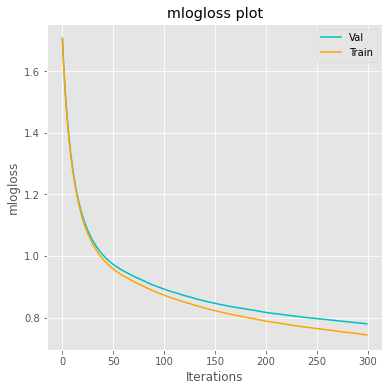

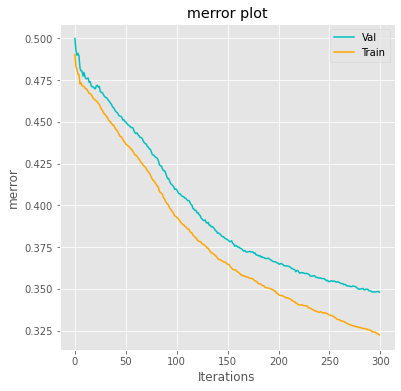

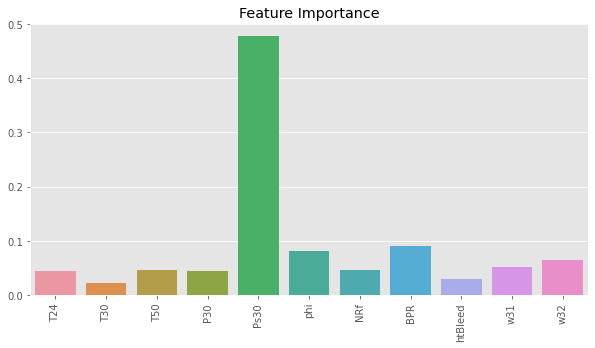

In [13]:
fitXgb(xgb1, training_data)

#### **Initial Model Evaluation**

In [13]:
pip install -U yellowbrick

     |████████████████████████████████| 276kB 7.8MB/s 
  Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1


##### **Classification Report**

In [14]:
from yellowbrick.classifier import ClassificationReport

**Validation Set**

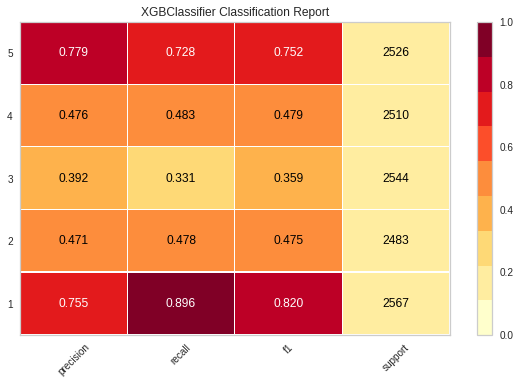

In [15]:
viz = ClassificationReport((xgb1), per_class=True, support=True)
viz.fit(X_train, y_train)
viz.score(X_val, y_val)
viz.show()

**Test Set**

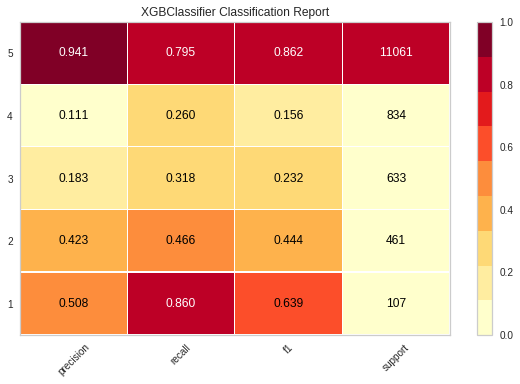

In [16]:
viz = ClassificationReport((xgb1), per_class=True, support=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

##### **ROC-AUC Receiver Operating Characteristic**

In [17]:
from yellowbrick.classifier import ROCAUC

**Validation Set**

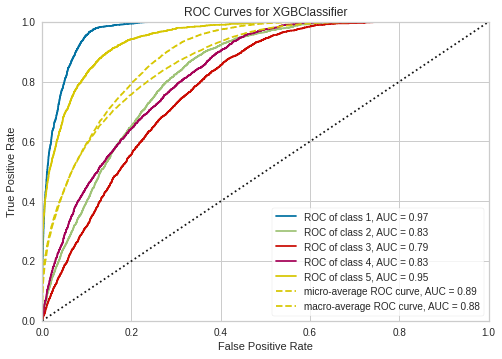

In [18]:
model = xgb1
visualizer = ROCAUC(model)
visualizer.fit(X_train, y_train)      
visualizer.score(X_val, y_val)
visualizer.show()

**Test Set**

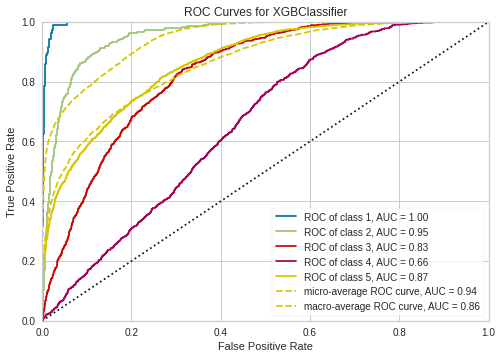

In [19]:
model = xgb1
visualizer = ROCAUC(model)
visualizer.fit(X_train, y_train)      
visualizer.score(X_test, y_test)
visualizer.show()

##### **Precision-Recall Curves**

In [20]:
from yellowbrick.classifier import PrecisionRecallCurve

**Validation Set**

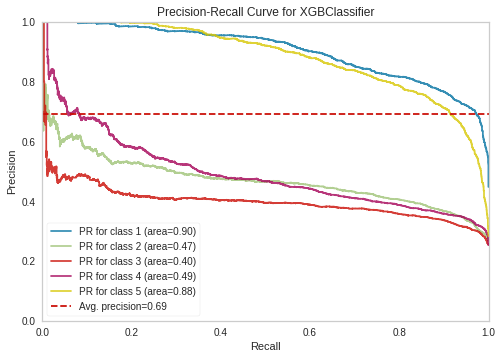

In [21]:
viz = PrecisionRecallCurve((xgb1), classes=[1,2,3,4,5], per_class=True)
viz.fit(X_train, y_train)
viz.score(X_val, y_val)
viz.show()

**Test Set**

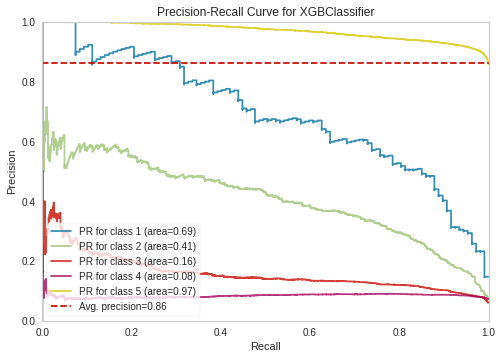

In [22]:
viz = PrecisionRecallCurve((xgb1), classes=[1,2,3,4,5], per_class=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

##### **Class Prediction Error**  

In [23]:
from yellowbrick.classifier import ClassPredictionError

**Validation Set**

In [24]:
y_val = y_val.flatten()

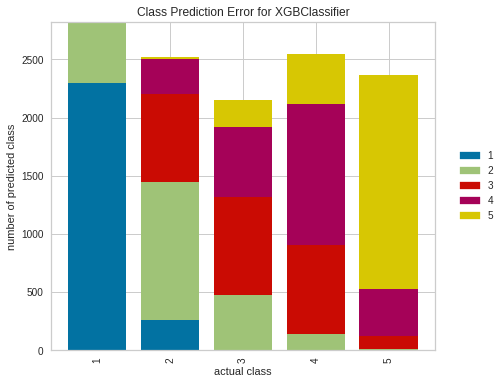

In [25]:
viz = ClassPredictionError((xgb1), per_class=True)
viz.fit(X_train, y_train)
viz.score(X_val, y_val)
viz.show()

**Test Set**

In [26]:
y_test = y_test.flatten()

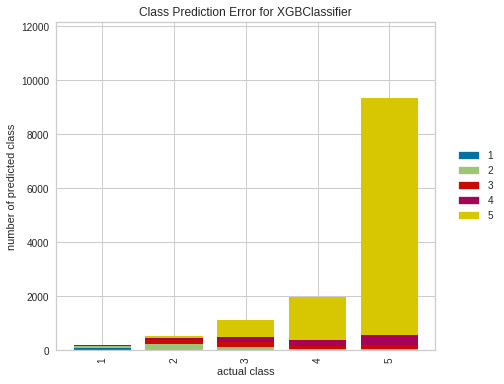

In [27]:
viz = ClassPredictionError(xgb1)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

##### **Confusion Matrix**  

In [28]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

**Validation Set**

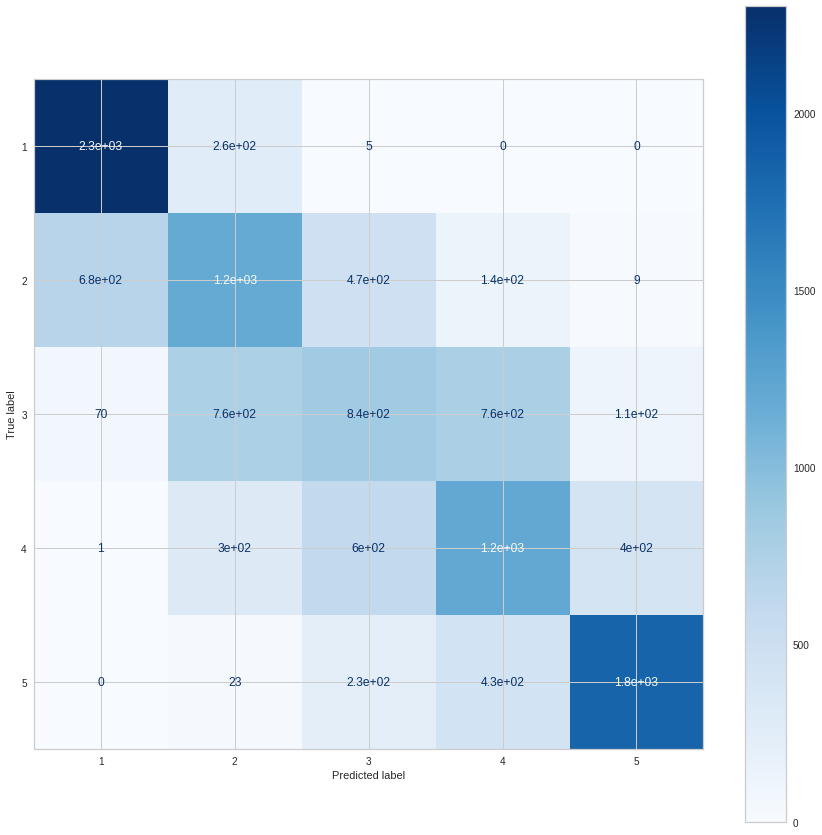

In [29]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(xgb1, X_val, y_val, cmap=plt.cm.Blues, ax=ax)

**Test Set**

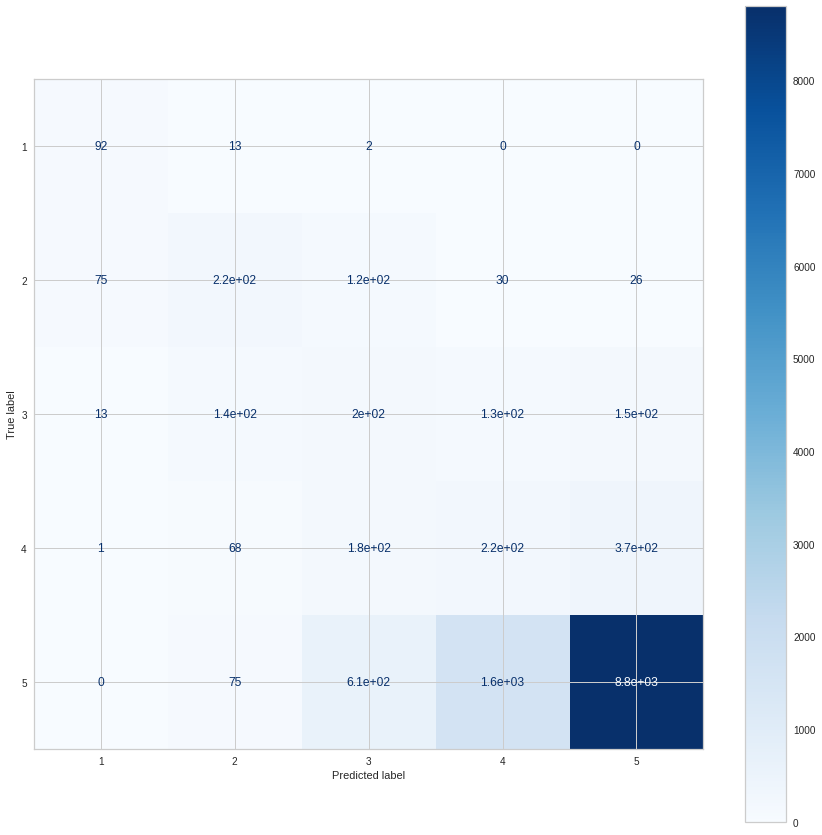

In [30]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(xgb1, X_test, y_test, cmap=plt.cm.Blues, ax=ax)

### **Tune max_depth and min_child_weight**

In [12]:
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_mean': gs.best_score_, "best_param":gs.best_params_}
    return results, best

In [13]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = xgb1, param_grid = param_test1, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch1.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 22.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, num_class=6,
                                     objective='multi:softmax', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=42, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             pre

In [14]:
getTrainScores(gsearch1)

({0: "mean:0.5907236364103731params{'max_depth': 3, 'min_child_weight': 1}",
  1: "mean:0.5900109885597193params{'max_depth': 3, 'min_child_weight': 3}",
  2: "mean:0.5895755311738029params{'max_depth': 3, 'min_child_weight': 5}",
  3: "mean:0.6520508144574853params{'max_depth': 5, 'min_child_weight': 1}",
  4: "mean:0.6506057579222213params{'max_depth': 5, 'min_child_weight': 3}",
  5: "mean:0.6486459616386687params{'max_depth': 5, 'min_child_weight': 5}",
  6: "mean:0.7075976252986951params{'max_depth': 7, 'min_child_weight': 1}",
  7: "mean:0.7062515335904005params{'max_depth': 7, 'min_child_weight': 3}",
  8: "mean:0.7021141937176143params{'max_depth': 7, 'min_child_weight': 5}",
  9: "mean:0.7649062498702006params{'max_depth': 9, 'min_child_weight': 1}",
  10: "mean:0.7578589949490164params{'max_depth': 9, 'min_child_weight': 3}",
  11: "mean:0.7529298698465192params{'max_depth': 9, 'min_child_weight': 5}"},
 {'best_mean': 0.7649062498702006,
  'best_param': {'max_depth': 9, 'min_

From the above GridSearch, we see that the best parameters for max_depth and min_child are 9 and 1 respectively.

Fitting model...
Fitting done!
[0]	val-mlogloss:1.67729	val-merror:0.401108	train-mlogloss:1.66653	train-merror:0.341674
[100]	val-mlogloss:0.602777	val-merror:0.226287	train-mlogloss:0.448663	train-merror:0.115943
[200]	val-mlogloss:0.473043	val-merror:0.158828	train-mlogloss:0.268111	train-merror:0.033475
[299]	val-mlogloss:0.401792	val-merror:0.132462	train-mlogloss:0.166661	train-merror:0.008591
-- Model Report --
XGBoost Accuracy: 0.8469761759315821
XGBoost F1-Score (Micro): 0.846976175931582


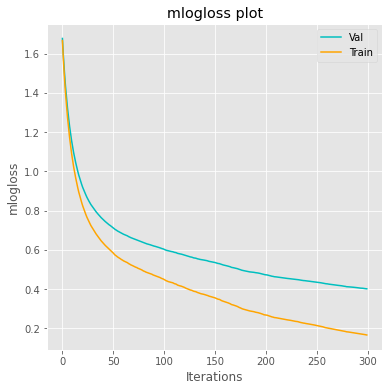

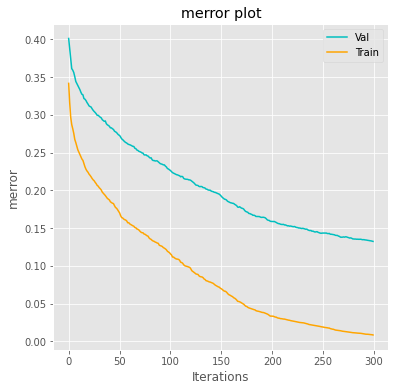

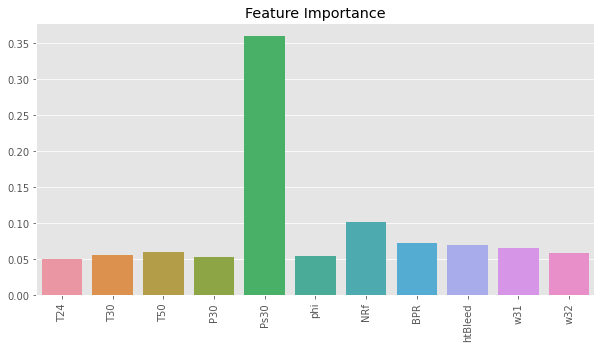

In [15]:
xgb2 = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=9,
                    min_child_weight=1,
                    objective='multi:softmax',
                    num_class=6,
                    seed=42)

fitXgb(xgb2, training_data)

### **Tune n_estimators**

In [16]:
param_test2 = {
 'n_estimators':range(100,1000,50),
}
gsearch2 = GridSearchCV(estimator = xgb2, param_grid = param_test2, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=3)
gsearch2.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 26.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 42.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 69.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 100.6min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 132.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=9, min_child_weight=1,
                                     missing=None, n_estimators=1000, n_jobs=1,
                                     nthread=None, num_class=6,
                                     objective='multi:softprob', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=42, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_estimators': range(100, 1000, 50)},
             pre_dispatch='2*n_jobs', refit=True, return_train_scor

In [17]:
getTrainScores(gsearch2)

({0: "mean:0.7560179578295242params{'n_estimators': 100}",
  1: "mean:0.7872951691153807params{'n_estimators': 150}",
  2: "mean:0.8132077520716349params{'n_estimators': 200}",
  3: "mean:0.8282920418292364params{'n_estimators': 250}",
  4: "mean:0.8402486539566909params{'n_estimators': 300}",
  5: "mean:0.8472761182570933params{'n_estimators': 350}",
  6: "mean:0.8534721827944146params{'n_estimators': 400}",
  7: "mean:0.8576688486588525params{'n_estimators': 450}",
  8: "mean:0.8596879944471915params{'n_estimators': 500}",
  9: "mean:0.8621822290054393params{'n_estimators': 550}",
  10: "mean:0.8644389526842867params{'n_estimators': 600}",
  11: "mean:0.8660028026678782params{'n_estimators': 650}",
  12: "mean:0.8670321838104441params{'n_estimators': 700}",
  13: "mean:0.867942780122473params{'n_estimators': 750}",
  14: "mean:0.8688335822937071params{'n_estimators': 800}",
  15: "mean:0.8693086745905162params{'n_estimators': 850}",
  16: "mean:0.8700213271433315params{'n_estimators'

From the above GridSearch, we see that the best parameters for n_estimators is 950.

Fitting model...
Fitting done!
[0]	val-mlogloss:1.67729	val-merror:0.401108	train-mlogloss:1.66653	train-merror:0.341674
[100]	val-mlogloss:0.602777	val-merror:0.226287	train-mlogloss:0.448663	train-merror:0.115943
[200]	val-mlogloss:0.473043	val-merror:0.158828	train-mlogloss:0.268111	train-merror:0.033475
[299]	val-mlogloss:0.401792	val-merror:0.132462	train-mlogloss:0.166661	train-merror:0.008591
-- Model Report --
XGBoost Accuracy: 0.8465943799633476
XGBoost F1-Score (Micro): 0.8465943799633476


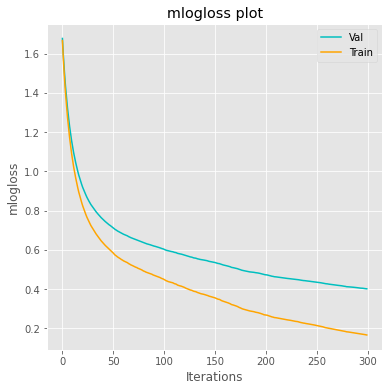

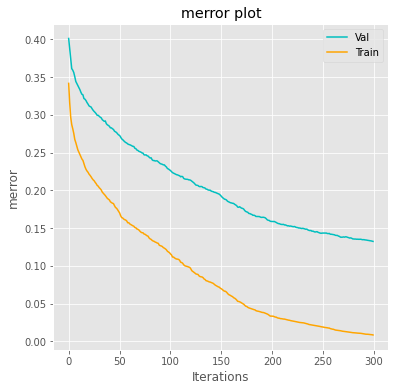

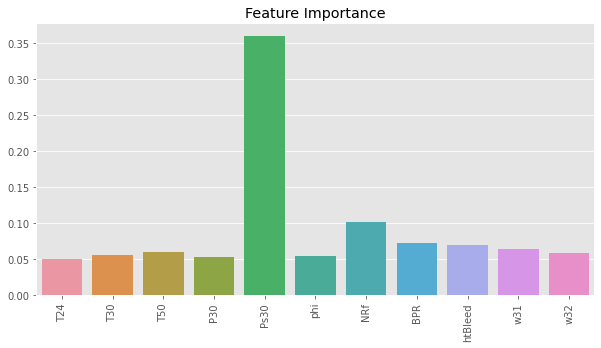

In [18]:
xgb3 = XGBClassifier(learning_rate=0.1,
                    n_estimators=950,
                    max_depth=9,
                    min_child_weight=1,
                    objective='multi:softmax',
                    num_class=6,
                    seed=42)

fitXgb(xgb3, training_data)

### **Tune reg_alpha**

In [ ]:
param_test3 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch3 = GridSearchCV(estimator = xgb3, param_grid = param_test3, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=3)
gsearch3.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 43.6min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 55.5min finished


In [ ]:
getTrainScores(gsearch3)

In [ ]:
xgb4 = XGBClassifier(learning_rate=0.1,
                    n_estimators=950,
                    max_depth=9,
                    min_child_weight=1,
                    reg_alpha=0.01,
                    objective='multi:softmax',
                    num_class=6,
                    seed=42)

fitXgb(xgb4, training_data)